In [16]:
import numpy as np

nan = np.nan

#ARRAY FOR TRANSITION PROB
P = np.array([ #SHAPE == [s,a,s']
    [[.7,.3,0],[1,0,0],[.8,.2,0]], #State 0's Probabilities (of A0 A1 A2)
    [[0,1,0],[nan,nan,nan],[0,0,1]],#State 1's Trans Probs
    [[nan,nan,nan],[.8,.1,.1],[nan,nan,nan]]
])


In [6]:
#Array for RETURNS (Rewards?)
R = np.array([ #Shape -- (Hold Reward, Buy Reward, Sell Reward) ?  OR Same [s,a,s']
    [[50,0,0],[0,0,0],[0,0,0]],
    [[50,0,0],[nan,nan,nan],[0,0,-250]], #THIS is SELL from Stagnant (Hold, Buy, Sell)
    [[nan,nan,nan],[200.0,0,0],[nan,nan,nan]]
])


#Actions (Per State)

    #S0,     S1.    S2.  --- from S0, can hold,buy, sell. (From S1, can Hold, Sell) (S2 -> only Buy)
A = [[0,1,2],[0,2],[1]]



In [38]:
#Now run QValue Iteration
Q = np.full((3,3),-np.inf)

    #IDX,  Value 
for state, actions in enumerate(A):
    Q[state, actions] = 0.0         #Initial value == 0
    

discount_rate = .95       #DISC of FUT rewards
n_iterations = 100        #Batches

#N Iterations (to run)
for iteration in range(n_iterations):
    
    Q_prev = Q.copy()       #COPY it! (To reference for each iter)
    for s in range(3):      #Loop through STATES
        for a in A[s]:      #LOOP through ACTIONS (PER state!)   Actions for State 0, then WHICH action
                            #Was T?     
                              #Prob      *  Curr Reward + y* MAX Future Reward (by looping tthrouhg all options)
            Q[s,a] = np.sum([ P[s,a,sp] * (R[s,a,sp] + discount_rate * np.max(Q_prev[sp])) for sp in range(3)])
print(Q)

print(f'\nInterpreted as OPTIMAL policy in EACH state....')

print(f'\nEX: If in State 0 -- Options are {Q[0]}')
print(f' -> best option in state == np.argmax(Q[state]): {np.argmax(Q[0])}\n')
print(f'S0 (Bull Mkt): Optimal: {np.argmax(Q[0])} --> {Q[0][np.argmax(Q[0])]}')
print(f'S1 (Flat Mkt): Optimal: {np.argmax(Q[1])} --> {Q[1][np.argmax(Q[1])]}')
print(f'S2 (Bear Mkt): Optimal: {np.argmax(Q[2])} --> {Q[2][np.argmax(Q[2])]}')


for q_per_state in range(3):
    state = q_per_state
    print(f'S{state}: optimal action: {np.argmax(Q[state])} --> {Q[state][np.argmax(Q[state])]}')

[[109.43230584 103.95749333  84.274035  ]
 [  5.5402017          -inf   5.83515676]
 [        -inf 269.30353051         -inf]]

Interpreted as OPTIMAL policy in EACH state....

EX: If in State 0 -- Options are [109.43230584 103.95749333  84.274035  ]
 -> best option in state == np.argmax(Q[state]): 0

S0 (Bull Mkt): Optimal: 0 --> 109.4323058394244
S1 (Flat Mkt): Optimal: 2 --> 5.835156761507875
S2 (Bear Mkt): Optimal: 1 --> 269.30353050771623
S0: optimal action: 0 --> 109.4323058394244
S1: optimal action: 2 --> 5.835156761507875
S2: optimal action: 1 --> 269.30353050771623


In [41]:
''' NEW RL Algo... from SCRATCH'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque

In [46]:
import yfinance as yf

spy = yf.download('SPY')
spy.shape

dataset = spy

[*********************100%***********************]  1 of 1 completed


In [47]:
set_option('precision', 3)
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7071.000,7071.000,7071.000,7071.000,7071.000,7.071e+03
mean,144.937,145.797,143.978,144.935,119.851,8.451e+07
std,73.186,73.507,72.822,73.188,78.638,9.646e+07
min,43.344,43.531,42.812,43.406,25.655,5.200e+03
25%,99.970,100.860,98.944,99.944,71.054,7.864e+06
50%,127.380,128.180,126.500,127.390,93.667,5.829e+07
75%,184.100,184.615,182.980,184.160,160.729,1.207e+08
max,393.960,394.170,391.530,392.640,392.640,8.710e+08


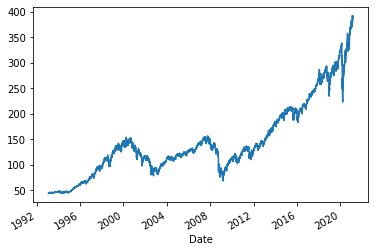

In [48]:
dataset.Close.plot()

In [49]:

# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.969,43.969,43.750,43.938,25.969,1003200
1993-02-01,43.969,44.250,43.969,44.250,26.154,480500


In [50]:
X=list(dataset["Close"])
X=[float(x) for x in X]

In [51]:
validation_size = 0.2
#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

In [56]:
#https://github.com/tatsath/fin-ml/blob/master/Chapter%209%20-%20Reinforcement%20Learning/Case%20Study%201%20-%20Reinforcement%20Learning%20based%20Trading%20Strategy/ReinforcementLearningBasedTradingStrategy.ipynb


import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from IPython.core.debugger import set_trace

import numpy as np
import random
from collections import deque


class Agent:
    def __init__(self, state_size, is_eval=False, model_name=''):
        #State size depends and is equal to the the window size, n previous days
        self.state_size = state_size
        self.action_size = 3 #Hold, Buy, Sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        
        self.model_name = model_name
        self.is_eval = is_eval
        
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = load_model(model_name) if is_eval else self._model()
        
    #Deep Q Learning model- returns the q-value when given state as input 
    def _model(self):
        model = Sequential()
        #Input Layer
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        #Hidden Layers
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        #Output Layer 
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
    
    #Return the action on the value function
    #With probability (1-$\epsilon$) choose the action which has the highest Q-value.
    #With probability ($\epsilon$) choose any action at random.
    #Intitially high epsilon-more random, later less
    
    #The trained agents were evaluated by different initial random condition
    #and an e-greedy policy with epsilon 0.05. 
    #This procedure is adopted to minimize the possibility of overfitting during evaluation.
    
    def act(self, state):
        #If it is test and self.epsilon is still very high, once the epsilon become low, there are no random
        #actions suggested.
        if not self.is_eval and random.random() <= self.epsilon:
            #RANDOM hit -- randomly choose bw 0 - 2
            return random.randrange(self.action_size)
        #Otherwise --> PREDICT!
        options = self.model.predict(state)
        return np.argmax(options[0]) #Should this be options[state] ? 
    
    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory) #1k
        #Record mini batch (start at end of memory, subtract batch size, up to end of mem)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        
        # the memory during the training phase. 
        #      St,     At,     Rt,       St+1,  Quit? 
        for state, action, reward, next_state, done in mini_batch:
            target = reward      # reward or Q at time t  
            
            #update the Q table based on Q table equation (IF not done)
            if not done:
                #Using BELLMAN equation
                pred_next = self.model.predict(next_state)[0] #WHY this 0? BC of ARRAY?
                target = reward + self.gamma * np.amax(pred_next)
            
            # Q-value of the CURRENT state from the table 
            target_f = self.model.predict(state)
            # Update Q Table 
            target_f[0][action] = target
            
            #Train
            #train and fit the model where state is X and target_f is Y, where the target is updated.
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        #DECAY epsilon (Optional) -> Reduces epsilon each time it's ran (UP to a min value)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            

In [60]:
'''Helper Functions'''
import math

# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# # returns the vector containing stock data from a fixed file 
# def getStockData(key):
#     vec = []
#     lines = open("data/" + key + ".csv", "r").read().splitlines()

#     for line in lines[1:]:
#         vec.append(float(line.split(",")[4])) #Only Close column

#     return vec


def sigmoid(p):
    return 1 / (1 + math.exp(-p))

# returns an an n-day state representation ending at time t

def getState(data, t, n):    
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

In [82]:
# def getState(data, t, n):   
#     #START at time - n (+ 1) -- get data window from n iter in batch to time.
#     d = t - n + 1
#     block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
#     #block is which is the for [1283.27002, 1283.27002]
#     res = []
#     for i in range(n - 1):
#         res.append(sigmoid(block[i + 1] - block[i]))
#     return np.array([res])


# getState(X_train,0,3)


# data = X_train
# d = 0 - 1 + 1
# t = 0
# n = 1
# block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
# block


# #These are exactly the same  (To avoid -index)
# print(data[d:t+1] if d >= 0 else 0)
# print(-d * [data[0]] + data[0:t + 1])

In [ ]:
## RUN the model...
from IPython.core.debugger import set_trace

window_size = 1
agent = Agent(window_size)
#In this step we feed the closing value of the stock price 
data = X_train
l = len(data) - 1
#
batch_size = 32
#An episode represents a complete pass over the data.
episode_count = 10

for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    #set_trace()
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in range(l):
        action = agent.act(state)    
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)      
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each 
            plot_behavior(data,states_buy, states_sell, total_profit)
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)    
            

    if e % 2 == 0:
        agent.model.save("model_ep" + str(e))

Running episode 0/10
Buy: $43.94
Sell: $44.25 | Profit: $0.31
Buy: $44.97
Buy: $44.97
Sell: $44.94 | Profit: -$0.03
Sell: $43.47 | Profit: -$1.50
Buy: $43.44
Buy: $43.41
Sell: $43.72 | Profit: $0.28
Sell: $43.69 | Profit: $0.28
Buy: $44.34
Sell: $44.41 | Profit: $0.06
Buy: $45.12
Buy: $44.75
Buy: $45.59
Sell: $45.31 | Profit: $0.19
Buy: $45.03
Sell: $45.03 | Profit: $0.28
Buy: $44.88
Buy: $45.16
Buy: $44.91
Sell: $45.09 | Profit: -$0.50
Buy: $45.22
Sell: $45.19 | Profit: $0.16
Sell: $44.31 | Profit: -$0.56
Sell: $44.19 | Profit: -$0.97
Buy: $44.28
Buy: $44.91
Buy: $45.00
Buy: $44.75
Buy: $44.53
Buy: $44.50
Buy: $43.88
Sell: $43.78 | Profit: -$1.12
Sell: $43.97 | Profit: -$1.25
Buy: $44.03
Sell: $44.31 | Profit: $0.03
Sell: $44.47 | Profit: -$0.44
Buy: $44.59
Sell: $44.44 | Profit: -$0.56
Sell: $44.34 | Profit: -$0.41
Sell: $44.62 | Profit: $0.09
Sell: $44.56 | Profit: $0.06
Sell: $44.00 | Profit: $0.12
Sell: $44.12 | Profit: $0.09
Sell: $45.16 | Profit: $0.56
Buy: $44.94
Sell: $45.03 |